In [14]:
import numpy as np 
import pandas as pd 
import os 
from tqdm import tqdm, trange
from datetime import datetime

import matplotlib.pyplot as plt 
import plotly.express as px 
from IPython.display import Audio

import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.nn import init

from sklearn.model_selection import train_test_split

In [15]:
class PATHS : 
    root_path = '/kaggle/input/'
    competition_path = os.path.join(root_path, 'birdclef-2024')
    enhanced_path = os.path.join(root_path, 'enhanced-birdclef-metadata')
    train_audio = os.path.join(competition_path, 'train_audio')
    unlabeled_soundscapes = os.path.join(competition_path, 'unlabeled_soundscapes')

sample_submission = pd.read_csv(os.path.join(PATHS.competition_path, "sample_submission.csv"))
taxonomy = pd.read_csv(os.path.join(PATHS.competition_path, "eBird_Taxonomy_v2021.csv"))
metadata = pd.read_csv(os.path.join(PATHS.enhanced_path, "enhanced_metadata.csv"))

# Encoding primary_label as numerical label 
NUM_CATEGORIES = metadata.primary_label.nunique()
labels = metadata.primary_label.unique()
metadata['nlabel'] = metadata.primary_label.map(dict(zip(labels, range(len(labels)))))

#NOTE : Need to fix csv file to remove index column
#TODO: Fix csv input
metadata = metadata.drop(columns=['Unnamed: 0'])

In [16]:
def get_spectrogram(filepath:str, duration=5.0, offset=0.0, pad=True) : 
    """
    Generates a mel spectrogram from an audio file.
    
    filepath: Local path in train_audio/ directory to audio file.
    duration: Window length, in seconds
    offset: Start time of sample
    pad: Whether to pad shorter samples to match duration
    """
    # Retrieving and loading data
    data, sr = librosa.load(os.path.join(PATHS.train_audio, filepath), offset=offset, duration=duration)
    
    # Padding to desired duration
    if pad and ((sample_dur := librosa.get_duration(y=data, sr=sr)) < duration) : 
        data = np.append(data, np.zeros(int((duration - sample_dur) * sr)))
    
    # Computing stft
    stft = librosa.stft(data, n_fft=1024)

    # Computing mel spectrogram 
    specmag, _ = librosa.magphase(stft)
    melspec = librosa.feature.melspectrogram(S=specmag, sr=sr)
    melspec = librosa.amplitude_to_db(melspec, ref=np.min)
    
    return melspec

def augment_spectrogram(spectrogram, normalize=True, max_noise=0.0, timetranslate=0.0, freqblock=0.0, timeblock=0.0) : 
    """
    Augments spectrogram data by normalizing, randomly translating, and/or adding noise.
    """
    
    if max_noise : 
        spectrogram = spectrogram + np.random.random() * max_noise * spectrogram.max() * np.random.random(spectrogram.shape)
    
    if normalize : 
        spectrogram = (spectrogram - spectrogram.mean())/spectrogram.std() if spectrogram.std() > 0 else spectrogram - spectrogram.mean()
    
    # Random translation
    if timetranslate : 
        spectrogram = np.roll(spectrogram, np.random.randint(spectrogram.shape[1]), axis=1)
        
    if freqblock : 
        # frequency blocking
        start_freq = np.random.randint(0, spectrogram.shape[0])
        blocklength = np.random.poisson(freqblock * spectrogram.shape[0])
        
        spectrogram[start_freq:start_freq+blocklength, :] = 0
        
    if timeblock :
        # time blocking
        start_time = np.random.randint(0, spectrogram.shape[1])
        blocklength = np.random.poisson(timeblock * spectrogram.shape[1])
        
        spectrogram[:, start_time:start_time+blocklength] = 0
    
    return spectrogram

In [33]:
class BirdCLEFDataset(Dataset) : 
    def __init__(self, metadata: pd.DataFrame, window_size=3.0, overlap=0.0, num_categories=NUM_CATEGORIES, aug_args=None) : 
        """
        metadata: Dataframe containing enhanced sample metadata, including filenames and nlabels
        window_size: Duration of samples, in seconds
        overlap: Percent of overlap between windows, lying in the range [0, 1)
        """
        self.metadata = metadata
        self.window_size = window_size
        self.overlap = overlap
        self.num_categories = num_categories
        self.aug_args = aug_args or dict(max_noise=0.0, freqblock=0.0, timeblock=0.0)
        
        # Get cumulative number of samples per recording
        self.n_samples = np.ceil(self.metadata.duration / (self.window_size * (1.0 - self.overlap))).cumsum()
        
    def __len__(self) : 
        return int(self.n_samples.iloc[-1])
    
    def __getitem__(self, idx) : 
        
        # Find which recording the idx corresponds to
        data_loc = np.where(self.n_samples >= idx+1)[0].min()
        audio_path = os.path.join(PATHS.train_audio, self.metadata.filename.iloc[data_loc])
        
        # Get location within recording
        i = int(idx - ([0.0] + self.n_samples.to_list())[data_loc])
        
        # Load sample
        sample = augment_spectrogram(get_spectrogram(audio_path, offset=i*(self.window_size * (1.0 - self.overlap)), duration=self.window_size), **self.aug_args)
        X = torch.Tensor(sample)
        
        # Get label
        nlabel = self.metadata.nlabel.iloc[data_loc]
        y = F.one_hot(torch.as_tensor(nlabel), num_classes=self.num_categories).type(torch.float32)
        
        return X, y 

In [34]:
metadata_hq = metadata[metadata.rating >= 3.0]

train_metadata, val_metadata = train_test_split(metadata_hq, test_size=0.2, random_state=42, stratify=metadata_hq.nlabel)

train = BirdCLEFDataset(train_metadata, window_size=4.0, overlap=0.0, aug_args=dict(max_noise=1.0, freqblock=0.1, timeblock=0.05))
val = BirdCLEFDataset(val_metadata, window_size=4.0, overlap=0.5)

train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=64)

In [35]:
class BirdClassifier_1DCNN (nn.Module) : 
    
    def __init__(self, num_categories=NUM_CATEGORIES) : 
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm.
        self.conv1 = nn.Conv1d(128, 256, kernel_size=10, stride=2, padding=2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(256)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv1d(256, 256, kernel_size=10, stride=2, padding=2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(256)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv1d(256, 128, kernel_size=5, stride=2, padding=2)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(128)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv1d(128, 64, kernel_size=5, stride=2, padding=2)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(64)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        # in_features = 64 * 26 for 5 secs, 1344 for 4 sec, and 1024 for 3 sec inputs
        self.lin = nn.Linear(in_features=1344, out_features=num_categories)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
    
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Flatten for input to linear layer
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

In [36]:
# Define model
model = BirdClassifier_1DCNN()

# Optional: Load model from persistent storage
model.load_state_dict(torch.load('model_240603.pt'))

# Send to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print(f"Model running on {device}.")

Model running on cuda.


In [38]:
# Train the model (single epoch)
def train(model, device, train_loader, criterion=nn.CrossEntropyLoss(), optimizer=torch.optim.SGD(model.parameters(), lr=0.01), save_every=100) : 
    model.to(device)

    for i, (X, y) in enumerate(pbar := tqdm(train_loader)):
        X, y = X.to(device), y.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass 
        outputs = model(X)
        # Compute the loss
        loss = criterion(outputs, y)
        # Backward pass
        loss.backward()
        # Update the model parameters
        optimizer.step() 

        pbar.set_description(f'Loss: {loss.item():.2f}, Correct: {100 * (y.argmax(axis=1) == outputs.argmax(axis=1)).sum()/y.shape[0]:.1f}%')

        # Save model every n steps
        if i % save_every == 0 : 
            torch.save(model.state_dict(), modelname:=f"model_{datetime.now().strftime('%y%m%d')}.pt")

    torch.save(model.state_dict(), modelname:=f"model_{datetime.now().strftime('%y%m%d')}.pt")
    print(f"Model saved as {modelname}")
    
train(model, device, train_loader)

## Validation

In [39]:
def validate(model, device, val_loader, criterion=nn.CrossEntropyLoss()):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(pbar := tqdm(val_loader)):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y.argmax(dim=1)).sum().item()
            pbar.set_description(f"Loss: {loss.item():.2f}; Accuracy: {(predicted == y.argmax(dim=1)).sum().item() / X.shape[0]:.2f}")
    accuracy = correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy

In [41]:
validate(model, device, val_loader)

### Validation visualization

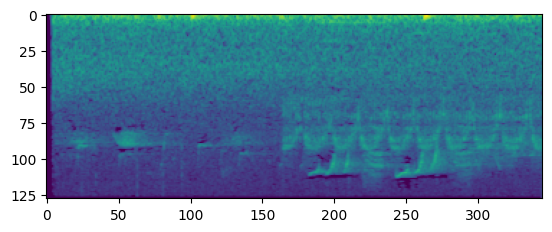

Predicted: 70 (P=0.30); Ans: 39, (P=0.02)


In [118]:
def valviz(model, device, val, idx=None) : 
    model.to(device)
    idx = idx or np.random.randint(0, len(val))
    
    X, y = val.__getitem__(idx)
    X, y = X.to(device), y.to(device)
    
    output = model(X.unsqueeze(0)).squeeze()
    
    plt.imshow(X.cpu().numpy())
    plt.show()
    
    ans = y.argmax().item()
    print(f"Predicted: {output.argmax().item()} (P={F.softmax(output, 0).max().item():.2f}); Ans: {ans}, (P={F.softmax(output, 0)[ans].item():.2f})")
    
    return output, y.argmax().item()

out, y = valviz(model, device, val)